<a href="https://colab.research.google.com/github/Squirtle007/Retrieval-Augmented_Generation/blob/main/Retrieval_Augmented_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAG with NVIDIA AI Foundation Models**

[**NGC**](https://catalog.ngc.nvidia.com/) allows developers to experience state-of-the-art LLMs accelerated on NVIDIA DGX Cloud with NVIDIA TensorRT and Triton Inference Server. Developers get **free credits for 10K requests** to any of the available models.

This notebook demonstrates how to use LangChain(https://python.langchain.com/docs/get_started/introduction) and NVIDIA AI Foundation Models to build a chatbot that references a custom knowledge-base.

Suppose you have some text documents (PDF, blog, Notion pages, etc.) and want to ask questions related to the contents of those documents. LLMs, given their proficiency in understanding text, are a great tool for this.

![](https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/rag-pipeline-ingest-query-flow-b.png)

### Part I: Install all necessary packages

In [1]:
!pip install langchain==0.1.4 unstructured==0.12.2 unstructured[pdf]==0.12.2 fastapi==0.109.0 kaleido==0.2.1 uvicorn==0.27.0 sentence-transformers==2.2.2 chromadb==0.4.22 langchain-nvidia-ai-endpoints==0.0.1
%reset -sf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.5/238.5 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 36.2 M

### Part II: Load Documents [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
LangChain provides a variety of [document loaders](https://python.langchain.com/docs/integrations/document_loaders) that load various types of documents (HTML, PDF, code) from many different sources and locations (private s3 buckets, public websites).

Document loaders load data from a source as **Documents**. A **Document** is a piece of text (the page_content) and associated metadata. Document loaders provide a ``load`` method for loading data as documents from a configured source.

In this example, we use a LangChain [`UnstructuredFileLoader`](https://python.langchain.com/docs/integrations/document_loaders/unstructured_file) to load a research paper about Llama2 from Meta.

[Here](https://python.langchain.com/docs/integrations/document_loaders) are some of the other document loaders available from LangChain.

In [2]:
!wget -O "ChipNeMo.pdf" -nc --user-agent="Mozilla" https://d1qx31qr3h6wln.cloudfront.net/publications/ChipNeMo%20%282%29.pdf

--2024-02-07 03:14:29--  https://d1qx31qr3h6wln.cloudfront.net/publications/ChipNeMo%20%282%29.pdf
Resolving d1qx31qr3h6wln.cloudfront.net (d1qx31qr3h6wln.cloudfront.net)... 18.155.70.208, 18.155.70.148, 18.155.70.206, ...
Connecting to d1qx31qr3h6wln.cloudfront.net (d1qx31qr3h6wln.cloudfront.net)|18.155.70.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 706559 (690K) [application/pdf]
Saving to: ‘ChipNeMo.pdf’

ChipNeMo.pdf        100%[===================>] 690.00K  --.-KB/s    in 0.01s   

2024-02-07 03:14:29 (69.0 MB/s) - ‘ChipNeMo.pdf’ saved [706559/706559]



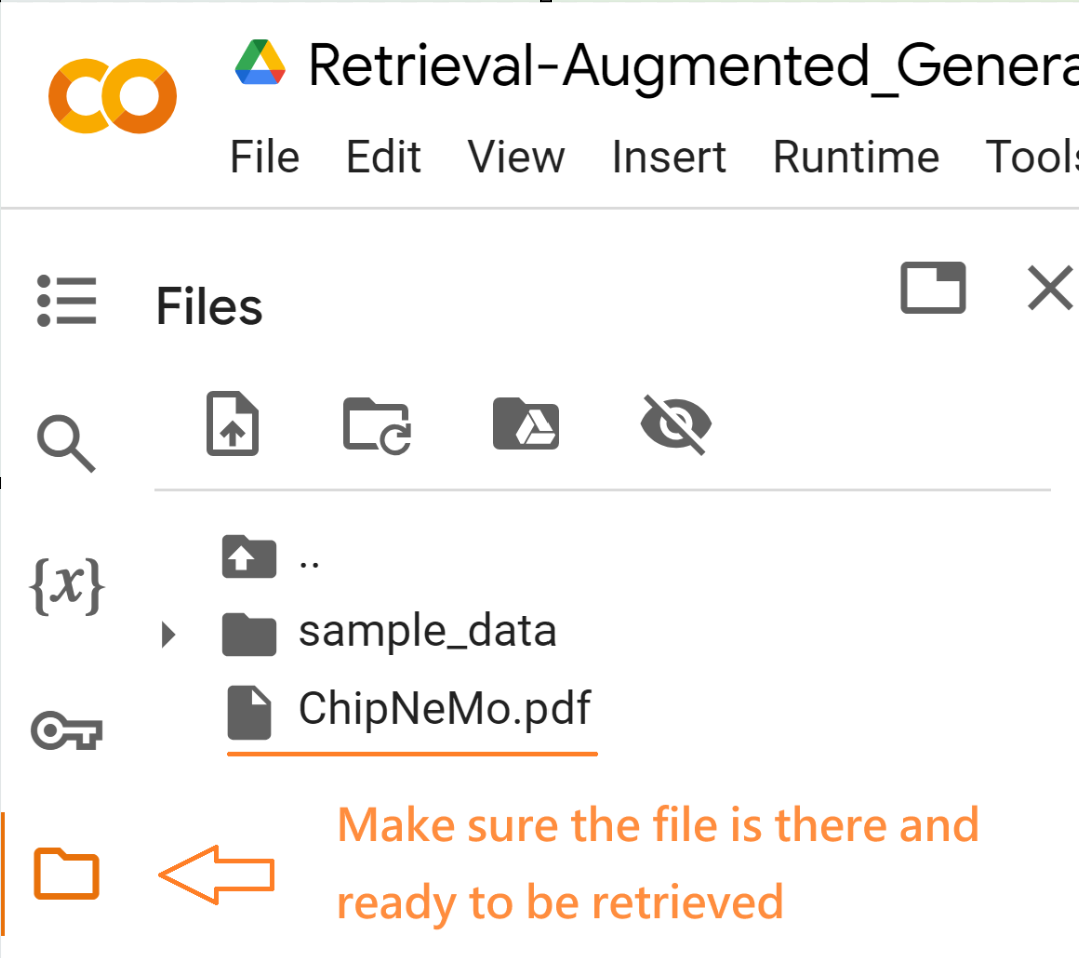

In [3]:
from langchain.document_loaders import UnstructuredFileLoader
loader = UnstructuredFileLoader("ChipNeMo.pdf")
data = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Part III: Transform Documents [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
Once documents have been loaded, they are often transformed. One method of transformation is known as **chunking**, which breaks down large pieces of text, for example, a long document, into smaller segments. This technique is valuable because it helps [optimize the relevance of the content returned from the vector database](https://www.pinecone.io/learn/chunking-strategies/).

LangChain provides a [variety of document transformers](https://python.langchain.com/docs/integrations/document_transformers/), such as text splitters. In this example, we use a [``SentenceTransformersTokenTextSplitter``](https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.SentenceTransformersTokenTextSplitter.html#langchain.text_splitter.SentenceTransformersTokenTextSplitter). The ``SentenceTransformersTokenTextSplitter`` is a specialized text splitter for use with the sentence-transformer models. The default behaviour is to split the text into chunks that fit the token window of the sentence transformer model that you would like to use. This sentence transformer model is used to generate the embeddings from documents.

Chunking is crucial for semantic search and RAG. It ensures coherence and context in responses. Disconnected content can lead to loss of coherence. You can customize **chunk size** and **chunk overlap** based on the document and analysis purpose.

In [4]:
import time
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
TEXT_SPLITTER_MODEL = "intfloat/e5-large-v2"
TEXT_SPLITTER_CHUNCK_SIZE = 510
TEXT_SPLITTER_CHUNCK_OVERLAP = 200

text_splitter = SentenceTransformersTokenTextSplitter(
    model_name=TEXT_SPLITTER_MODEL,
    chunk_size=TEXT_SPLITTER_CHUNCK_SIZE,
    chunk_overlap=TEXT_SPLITTER_CHUNCK_OVERLAP,
)
start_time = time.time()
documents = text_splitter.split_documents(data)
print(f"--- {time.time() - start_time} seconds ---")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

handler.py:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

--- 2.757455348968506 seconds ---


### Part IV: Generate Embeddings and Store Embeddings in the Vector Store [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)

#### a) Generate Embeddings
[Embeddings](https://python.langchain.com/docs/modules/data_connection/text_embedding/) for documents are created by vectorizing the document text; this vectorization captures the semantic meaning of the text. This allows you to quickly and efficiently find other pieces of text that are similar. The embedding model used below is [intfloat/e5-large-v2](https://huggingface.co/intfloat/e5-large-v2).

LangChain provides a wide variety of [embedding models](https://python.langchain.com/docs/integrations/text_embedding) from many providers and makes it simple to swap out the models.

When a user sends in their query, the query is also embedded using the same embedding model that was used to embed the documents. As explained earlier, this allows to find similar (relevant) documents to the user's query.

#### b) Store Document Embeddings in the Vector Store
Once the document embeddings are generated, they are stored in a vector store so that at query time we can:
1) Embed the user query and
2) Retrieve the embedding vectors that are most similar to the embedding query.

A vector store takes care of storing the embedded data and performing a vector search.

LangChain provides support for a [great selection of vector stores](https://python.langchain.com/docs/integrations/vectorstores/).

<div class="alert alert-block alert-info">
    
⚠️ For this workflow, [chroma](https://www.trychroma.com/) is used for vector database (DB)

</div>

In [5]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
import torch
import time

#Running the model on CPU as we want to conserve gpu memory.
#In the production deployment (API server shown as part of the 5th notebook we run the model on GPU)
model_name = "intfloat/e5-large-v2"
model_kwargs = {"device": "cuda:0"}    #Change to {"device": "cpu"} for CPU implementation
encode_kwargs = {"normalize_embeddings": False}
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)
start_time = time.time()
vectorstore = Chroma.from_documents(documents, hf_embeddings)
print(f"--- {time.time() - start_time} seconds ---")

--- 8.956104516983032 seconds ---


Note that running the embedding model on an **NVIDIA GPU** (T4) is significantly faster than on a CPU:

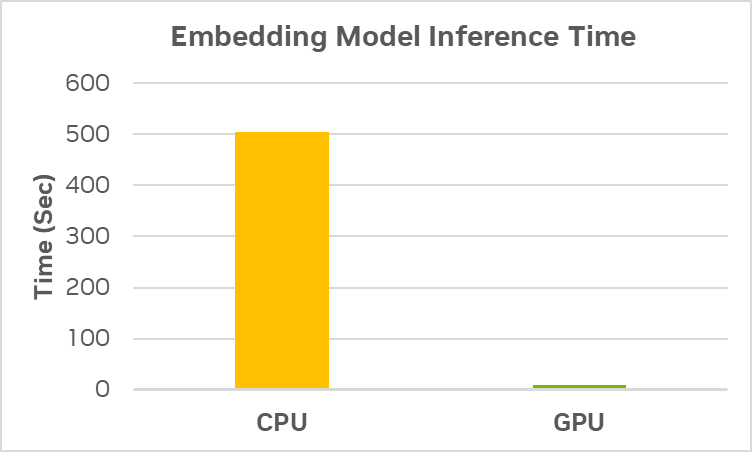


### Part V: Sign up to NVIDIA AI Foundation Models

Let's explore powerful Large Language Models (LLMs) on NVIDIA AI Foundation Models. Sign up for free credits, follow the [**instructions**](https://github.com/Squirtle007/Retrieval-Augmented_Generation/blob/main/README.md), and try out the "Mixtral 8x7B" model in this example.

In [8]:
import os

os.environ['NVIDIA_API_KEY'] = "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"

The **ChatNVIDIA** is a chat model that connects to NVIDIA AI Foundation Endpoints.
The model and its corresponding hyperparameters can be customized. For instance, you can adjust the **temperature** setting to control the randomness of the model's output.

In [9]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.output_parsers import StrOutputParser

llm = ChatNVIDIA(model="mixtral_8x7b", temperature=0.1, max_tokens=100, top_p=1.0)| StrOutputParser()

### Part VI: Ask a question without context

Send request to the LLM without any context from the vector DB. The answer is generic and irrelvant.

In [20]:
question = "What is ChipNeMo?"

answer = llm.invoke(question)
print(answer)

Thank you for your thoughtful guidelines. I'm happy to help!

ChipNeMo is not a widely recognized term or concept in the technology or chip-making industry. It is possible that it could be a specific term used within a certain company or project, but without more context, it's difficult for me to provide a precise definition.

However, based on the individual words that make up the term, it could potentially refer to a "chip" (short for microchip or integrated circuit) that is related to "neuro" (short for neuroscience or neural networks) and "motion" (related to movement or mobility). So, one possible interpretation of ChipNeMo could be a chip designed for neural network-based motion control or a similar application.

Without further information, this is just a speculative interpretation, and I would recommend seeking clarification from the source that used the term to ensure an accurate understanding.


The following cell is optional for prompting the LLM. For example, it can be used to stop the model when uncertain knowledge is encountered.

In [28]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [("system", "If uncertain about the answer, admit you don't know. Otherwise, feel free to answer."), ("user", "{input}")]
)
chain = prompt | ChatNVIDIA(model="llama2_13b") | StrOutputParser()

for txt in chain.stream({"input": question}):
    print(txt, end="")

I don't know what ChipNeMo is. I'm just an AI and I don't have information about every topic or technology. If you have more context or information about ChipNeMo, I may be able to help you better.

### Part VII: Compose a streamed answer using a Chain
NVIDIA integrated [**TensorRT-LLM**](https://developer.nvidia.com/blog/nvidia-tensorrt-llm-supercharges-large-language-model-inference-on-nvidia-h100-gpus/) into [LangChain chain](https://python.langchain.com/docs/modules/chains/), handling document loading, transformation, embedding generation, and storage.



To complete the pipeline, we use a [RetrievalQA chain](https://js.langchain.com/docs/modules/chains/popular/vector_db_qa/), which is a chain type for question-answering against a vector index. It combines using a *Retrieval* and *question-answering (QA) chain*.

Note that **TensorRT-LLM** significantly boosts the inference efficiency for the foundation model:

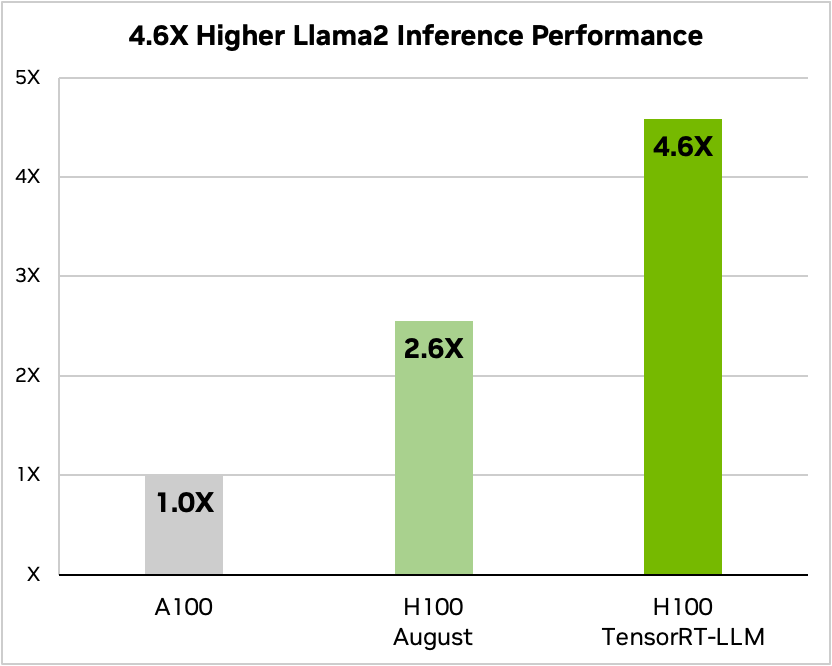

Lastly, we pass a user query to the chain and stream the result.

In [11]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever()    #Retriever is an interface that returns documents given an unstructured query
)
result = qa_chain.invoke({"query": question})
result['result']

'ChipNeMo is a project that explores the applications of Large Language Models (LLMs) in the field of industrial chip design. Instead of directly deploying off-the-shelf commercial or open-source LLMs, ChipNeMo adopts domain adaptation techniques such as custom tokenizers, domain-adaptive continued pretraining, supervised fine-tuning with domain-specific instructions, and domain-adapted retrieval models. These techniques are evaluated on three selected LLM applications for chip design: an engineering assistant chatbot, EDA script generation, and bug summarization and analysis. The findings show that these domain adaptation techniques enable significant LLM performance improvements over general-purpose base models, reducing model size while maintaining or improving performance on a range of design tasks.'